### Goal: train RNN network on single trial data (not trial averaged)

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import mat73

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
from tools.dsp.preprocessing import preprocess

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
fname = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata_0.mat")

df = pyal.mat2dataframe(fname, shift_idx_fields=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_imec0_KSLabel could not be converted to int.


### PROCESSING DATAFRAME

In [6]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off
df_ = pyal.select_trials(df_, "values_Sol_direction == 0")  # to test RNN training only use a subset of trials

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_imec0_spikes ephys data shape is (NxT): (449, 133)


In [7]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_imec0_chan_best,all_imec0_unit_guide,all_imec0_KSLabel,all_imec0_spikes,all_imec0_rates,sol_level_id,sol_contra_ipsi
0,M044,M044_2024_12_04_09_30,102,trial,401,0.03,32966,33099,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.038744207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0,0
1,M044,M044_2024_12_04_09_30,108,trial,401,0.03,33933,34066,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.00031967516, 0.003973114, 0.0, 0.0, 0.0347...",0,0
2,M044,M044_2024_12_04_09_30,120,trial,401,0.03,35866,35999,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.003973114, 10.21812, 0.0, 10.21812, 0.0, 0...",0,0
3,M044,M044_2024_12_04_09_30,128,trial,401,0.03,36866,36999,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.015139, 0.0, 0.0, 10.222094, 0.003973114, ...",0,0
4,M044,M044_2024_12_04_09_30,140,trial,401,0.03,38466,38599,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[23.167597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,0


In [8]:
# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["M1", "Dls"]
df_["M1_rates"] = [df_["all_imec0_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_imec0_rates"][i][:,0:300] for i in range(len(df_))]

# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.sol_level_id.unique()
sol_angles.sort()

# number of trials in data
num_trials = len(df_)

### CONCATINATE ALL TRIALS

In [9]:
df_concat_trials = pyal.concat_trials(df_, signal = "all_imec0_rates")

### PLOT RNN INPUT

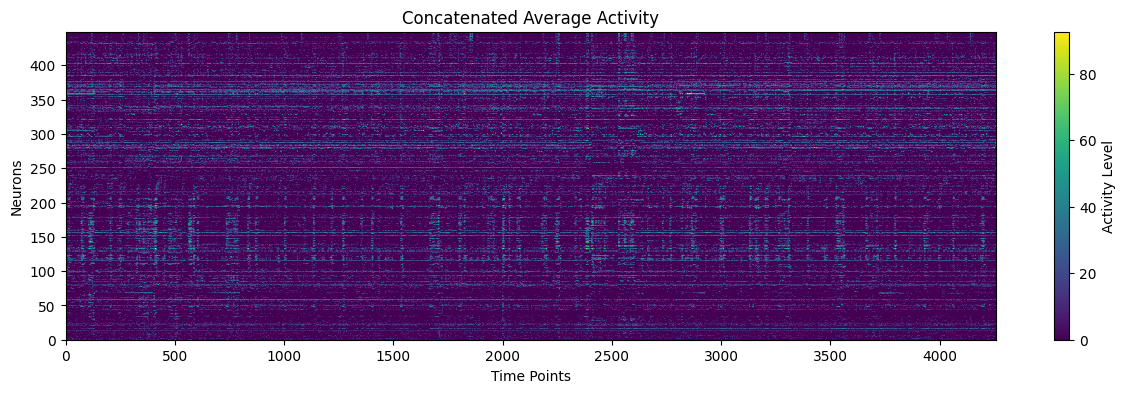

In [10]:
plt.figure(figsize=(15, 4))  # Set figure size
plt.pcolormesh(df_concat_trials.T, cmap='viridis', shading='auto')
plt.colorbar(label='Activity Level')
plt.title('Concatenated Average Activity')
plt.xlabel('Time Points')
plt.ylabel('Neurons')
plt.show()

SETTING UP VARIABLES FOR RNN

In [11]:
if df_["M1_rates"][0].shape[0] == df_["Dls_rates"][0].shape[0] == df_["all_imec0_rates"][0].shape[0]:
    trial_len = df_["Dls_rates"][0].shape[0]
else:
    print(f"Variable trial length!")

reset_points = []
for i in range(len(df_)):
    reset_points.append(i*trial_len)
# new change

In [12]:
activity = np.transpose(df_concat_trials)
Na = df_.M1_rates[1].shape[1]
Nb = df_.Dls_rates[1].shape[1]
print(Na, Nb)

regions = [['M1', np.arange(0, Na)], ['Dls', np.arange(Na, Na + Nb)]]
regions = np.array(regions, dtype=object)
print(f"Building {len(regions)} region RNN network")
print(f"Regions: {regions[:, 0]} with {Na} neurons for {regions[0,0]} and {Nb} neurons for {regions[1,0]}.\n")

149 300
Building 2 region RNN network
Regions: ['M1' 'Dls'] with 149 neurons for M1 and 300 neurons for Dls.



## TRAIN RNN

In [13]:
model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df_.bin_size[0],
                                  dtFactor=1,
                                  tauRNN = 0.2,
                                  ampInWN= 0.01,
                                  g = 1.5,
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=True,
                                  plotStatus=False,
                                  nRunFree=5,
                                  resetPoints=reset_points)

trial=0 pVar=0.299301 chi2=25.763710
trial=1 pVar=0.444467 chi2=21.097178
trial=2 pVar=0.462729 chi2=20.365002
trial=3 pVar=0.474590 chi2=19.847348
trial=4 pVar=0.480977 chi2=19.571829
trial=5 pVar=0.487760 chi2=19.289629
trial=6 pVar=0.494207 chi2=19.025958
trial=7 pVar=0.500114 chi2=18.784551
trial=8 pVar=0.505345 chi2=18.573775
trial=9 pVar=0.508776 chi2=18.433561
trial=10 pVar=0.511162 chi2=18.339295
trial=11 pVar=0.513195 chi2=18.264760
trial=12 pVar=0.515247 chi2=18.189191
trial=13 pVar=0.517225 chi2=18.110495
trial=14 pVar=0.517994 chi2=18.074615
trial=15 pVar=0.517630 chi2=18.083605
trial=16 pVar=0.517450 chi2=18.090174
trial=17 pVar=0.517587 chi2=18.088203
trial=18 pVar=0.518132 chi2=18.071799
trial=19 pVar=0.519284 chi2=18.031242
trial=20 pVar=0.520864 chi2=17.972329
trial=21 pVar=0.522344 chi2=17.915525
trial=22 pVar=0.523306 chi2=17.877503
trial=23 pVar=0.523679 chi2=17.861635
trial=24 pVar=0.523642 chi2=17.861495
trial=25 pVar=0.523449 chi2=17.867387
trial=26 pVar=0.523297

#### plot pVar and chi2

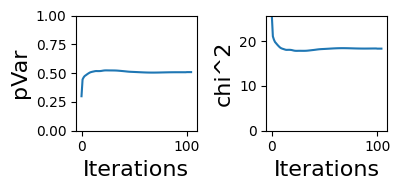

In [14]:
fig = pylab.figure(figsize=[4, 2])

axn = fig.add_subplot(1, 2, 1)
axn.plot(model['pVars'])
axn.set_ylabel("pVar", fontsize=16)
axn.set_xlabel("Iterations", fontsize=16)
axn.set_ylim(0, 1)

axn = fig.add_subplot(1, 2, 2)
axn.plot(model['chi2s'])
axn.set_ylabel("chi^2", fontsize=16)
axn.set_xlabel("Iterations", fontsize=16)
axn.set_ylim(0, np.max(model['chi2s']))

fig.tight_layout()
fig.show()

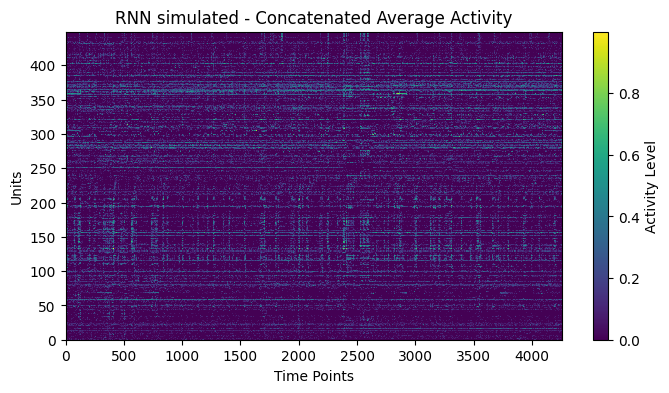

In [15]:
plt.figure(figsize=(8, 4))  # Set figure size
plt.pcolormesh(model['Adata'], cmap='viridis', shading='auto')
plt.colorbar(label='Activity Level')
plt.title('RNN simulated - Concatenated Average Activity')
plt.xlabel('Time Points')
plt.ylabel('Units')
plt.show()

## CURBD

plot currents (code from the test_CURBD.ipynb)

In [16]:
curbd_arr, curbd_labels = curbd.computeCURBD(model)

x:  (4256,) y:  149 C:  (149, 4256) 

x:  (4256,) y:  149 C:  (149, 4256) 

x:  (4256,) y:  300 C:  (300, 4256) 

x:  (4256,) y:  300 C:  (300, 4256) 



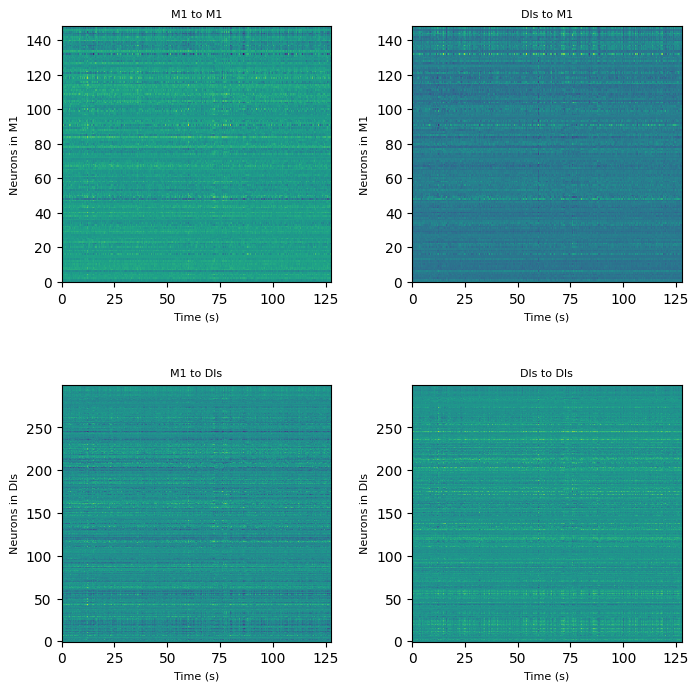

In [17]:
n_regions = curbd_arr.shape[0]

fig = pylab.figure(figsize=[8, 8])
count = 1
for iTarget in range(n_regions):
    for iSource in range(n_regions):
        axn = fig.add_subplot(n_regions, n_regions, count)
        count += 1
        n_region_units = curbd_arr[iTarget, iSource].shape[0]
        print("x: ", model['tRNN'].shape, "y: ", len(range(n_region_units)), "C: ", curbd_arr[iTarget, iSource].shape, "\n")
        axn.pcolormesh(model['tRNN'], range(n_region_units),
                       curbd_arr[iTarget, iSource]) # time x neurons
        axn.set_xlabel('Time (s)')
        axn.set_ylabel('Neurons in {}'.format(regions[iTarget, 0]))
        axn.set_title(curbd_labels[iTarget, iSource])
        axn.title.set_fontsize(8)
        axn.xaxis.label.set_fontsize(8)
        axn.yaxis.label.set_fontsize(8)
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.show()

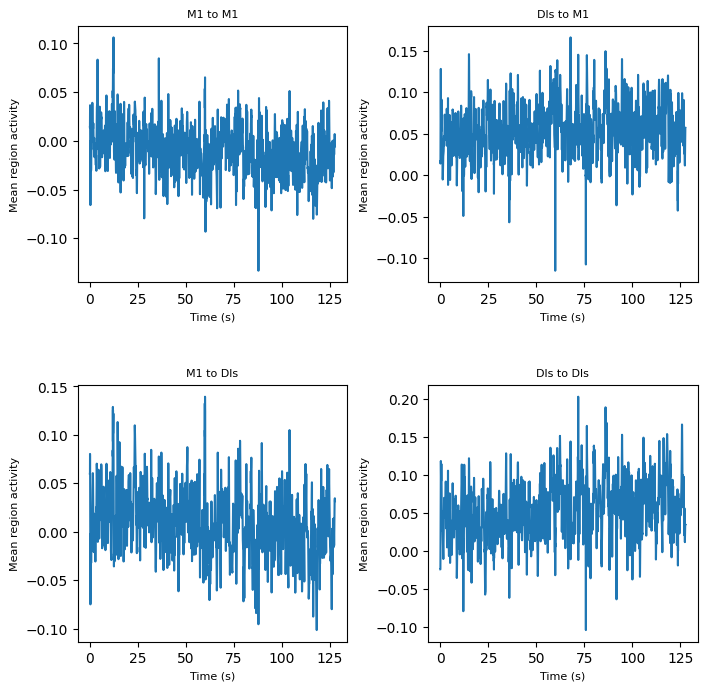

In [18]:

fig = pylab.figure(figsize=[8, 8])
count = 1
for iTarget in range(n_regions):
    for iSource in range(n_regions):
        axn = fig.add_subplot(n_regions, n_regions, count)
        count += 1
        axn.plot(model['tRNN'], curbd_arr[iTarget, iSource].mean(axis = 0))
        axn.set_xlabel('Time (s)')
        axn.set_ylabel('Mean region activity')
        axn.set_title(curbd_labels[iTarget, iSource])
        axn.title.set_fontsize(8)
        axn.xaxis.label.set_fontsize(8)
        axn.yaxis.label.set_fontsize(8)
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.show()

### Plot trial averaged current changes

In [22]:
# set up variables for plotting
dtFactor = model['params']['dtFactor']
count = 1

M1_to_M1 = np.reshape(curbd_arr[0, 0], (Na, num_trials, -1))
Dls_to_M1 = np.reshape(curbd_arr[0, 1], (Na, num_trials, -1))
M1_to_Dls = np.reshape(curbd_arr[1, 0], (Nb, num_trials, -1))
Dls_to_Dls = np.reshape(curbd_arr[1, 1], (Nb, num_trials, -1))

all_currents = [M1_to_M1, Dls_to_M1, M1_to_Dls, Dls_to_Dls]
all_currents_labels = ["M1 to M1", "Dls to M1", "M1 to Dls", "Dls to Dls"]

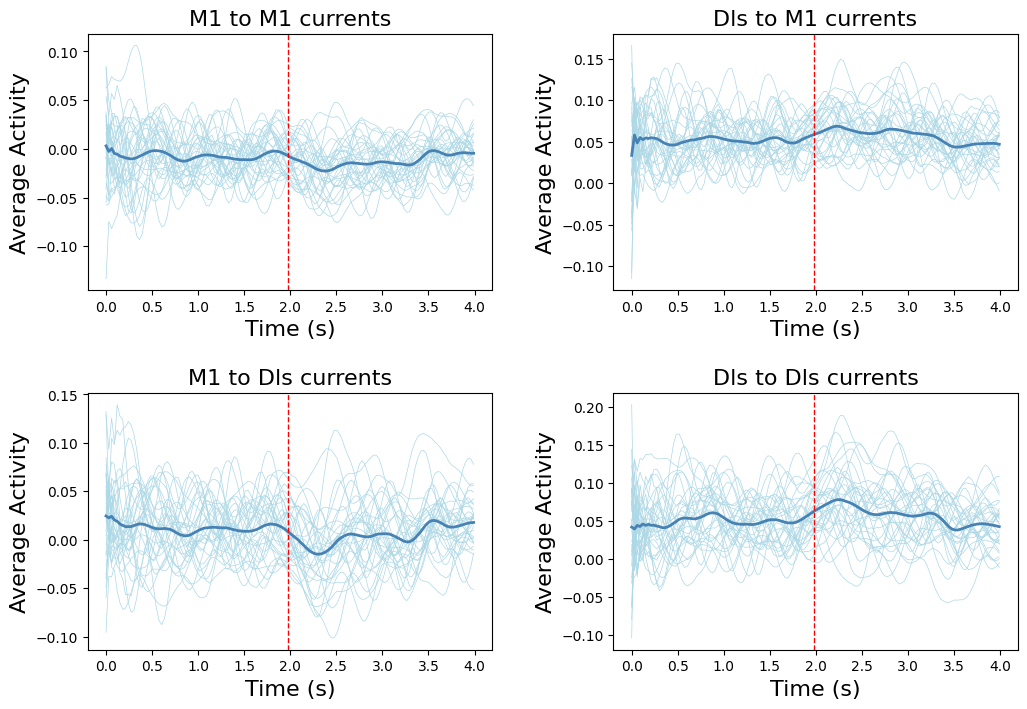

In [23]:
fig = pylab.figure(figsize=[12, 8])
count = 1

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    axn = fig.add_subplot(2, 2, count)
    count += 1

    # plotting each trial current
    for trial_index in range(num_trials):
        arr = current_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis = 0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)

    # plotting mean current for trial
    mean_current = np.mean(current_data, axis=(0, 1))
    
    axn.plot(time_axis, mean_current, color='steelblue', linewidth=2)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label = 'Perturbation time')

    axn.set_title(f'{current_label} currents')
    axn.set_xlabel('Time (s)')
    axn.set_ylabel('Average Activity')
    axn.title.set_fontsize(16)
    axn.xaxis.label.set_fontsize(16)
    axn.yaxis.label.set_fontsize(16)
    
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.show() 

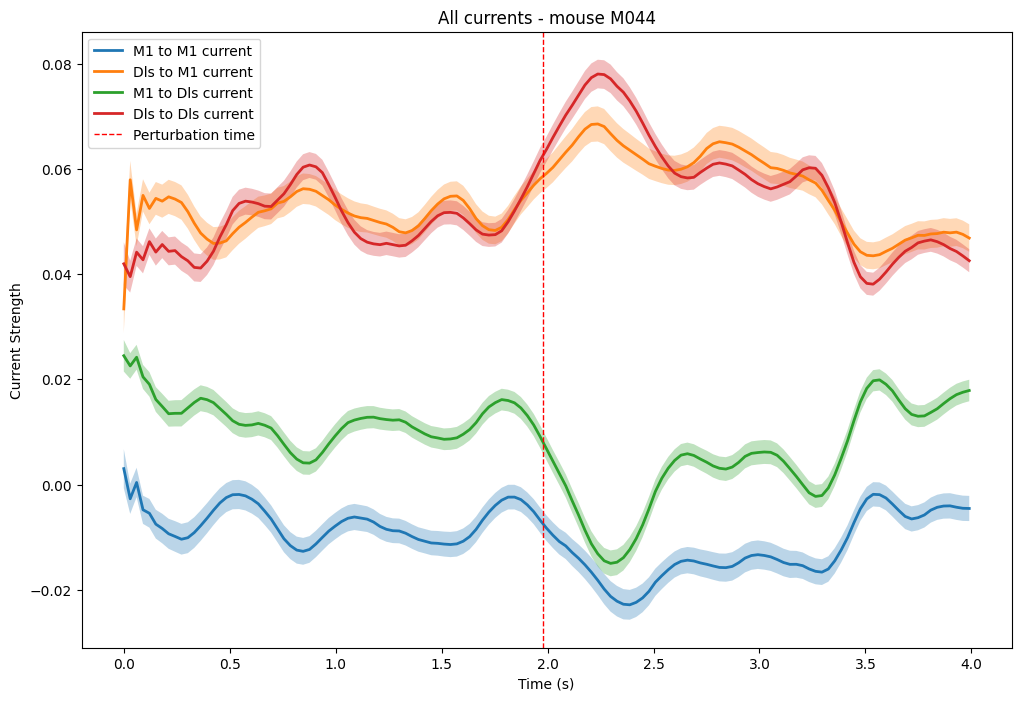

In [24]:
fig = pylab.figure(figsize=[12, 8])

for i in range(len(all_currents)):

    current_data = all_currents[i]
    current_label = all_currents_labels[i]
    time_axis = np.linspace(0, current_data.shape[2] * df_.bin_size[0], current_data.shape[2])

    # plotting each trial current
    for trial_index in range(num_trials):
        arr = current_data[:, trial_index, :]
        trial_mean = np.mean(arr, axis = 0)
        axn.plot(time_axis, trial_mean, color='lightblue', linewidth=0.5)

    # plotting mean current for trial
    mean_current = np.mean(current_data, axis=(0, 1))
    sem_current = np.std(current_data, axis=(0, 1)) / np.sqrt(current_data.shape[0] * current_data.shape[1])
    
    pylab.plot(time_axis, mean_current, linewidth=2, label=f'{current_label} current')
    pylab.fill_between(time_axis, mean_current - sem_current, mean_current + sem_current, alpha=0.3)

    axn.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label = 'Perturbation time')

# Add a red vertical line at time 0
pylab.axvline(perturbation_time_seconds, color='red', linestyle='--', linewidth=1, label='Perturbation time')
# Set labels and title
pylab.title('All currents - mouse M044')
pylab.xlabel('Time (s)')
pylab.ylabel('Current Strength')
pylab.legend(loc='upper left')
pylab.show()
